In [187]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('Data\\ts_dataset_firenze.csv', index_col ='index', parse_dates=True)
df.index.freq='MS'
#i

In [188]:
df = df.loc[:'2019']
df.tail()

,prezzi_vendita,reddito,arrivi_tot,arrivi_ita,arrivi_str,anagr_altri_com_canc,anagr_altri_com_iscr,canc_anagr,canc_anagr_altrimot,canc_anagr_est,...,ADD_HI,UL_JKL,ADD_JKL,UL_MN,ADD_MN,UL_OPQ,ADD_OPQ,UL_RSTU,ADD_RSTU,reddito_procapite_mens
index,,,,,,,,,,,,,,,,,,,,,
2019-08-01,3986.0,6.791836e+09,1156880.0,175439.0,981441.0,632.0,601.0,1435.0,403.0,46.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18192.677506
2019-09-01,4006.0,6.791836e+09,1156880.0,175439.0,981441.0,738.0,690.0,1783.0,660.0,48.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18208.333645
2019-10-01,4035.0,6.791836e+09,912846.0,307139.0,605707.0,800.0,823.0,1714.0,514.0,50.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18228.859053
2019-11-01,4050.0,6.791836e+09,912846.0,307139.0,605707.0,689.0,762.0,1646.0,550.0,41.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18234.585089
2019-12-01,4040.0,6.791836e+09,912846.0,307139.0,605707.0,666.0,626.0,1349.0,315.0,42.0,...,13427.96625,5501.5,4958.364167,12842.5,13885.33625,4200.0,5491.06875,2576.0,2694.18625,18248.744315


### ETS Decomposition

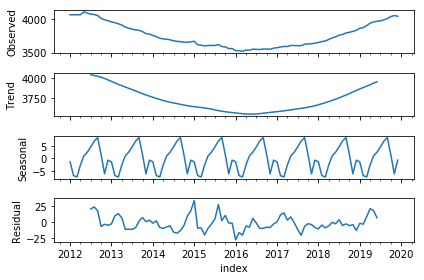

In [189]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['prezzi_vendita'], model='add')  # model='add' also works
result.plot();

Here we see that the seasonal component does not contribute significantly to the behavior of the series.

### Run the augmented Dickey-Fuller Test on the First Difference

In [190]:
#to perform differencing
from statsmodels.tsa.statespace.tools import diff
df['prezzi_vendita_d1'] = diff(df['prezzi_vendita'],k_diff=2)

In [191]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

 We perform a DF test. Data is non-stationary. Differencing (2) transform ir in stationary.

### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

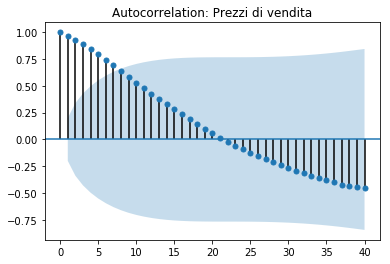

In [192]:
title = 'Autocorrelation: Prezzi di vendita'
lags = 40
plot_acf(df['prezzi_vendita'],title=title,lags=lags);

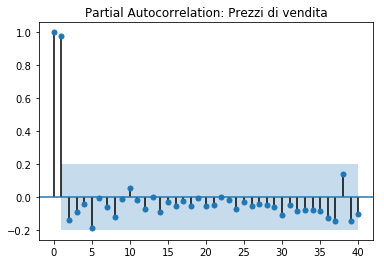

In [193]:
title = 'Partial Autocorrelation: Prezzi di vendita'
lags = 40
plot_pacf(df['prezzi_vendita'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

In [194]:
stepwise_fit = auto_arima(df['prezzi_vendita'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 2, 0); AIC=808.164, BIC=813.251, Fit time=0.016 seconds
Fit ARIMA: order=(1, 2, 0); AIC=777.892, BIC=785.522, Fit time=0.040 seconds
Fit ARIMA: order=(0, 2, 1); AIC=760.323, BIC=767.953, Fit time=0.036 seconds
Fit ARIMA: order=(1, 2, 1); AIC=762.250, BIC=772.423, Fit time=0.063 seconds
Fit ARIMA: order=(0, 2, 2); AIC=762.266, BIC=772.439, Fit time=0.062 seconds
Fit ARIMA: order=(1, 2, 2); AIC=763.321, BIC=776.037, Fit time=0.116 seconds
Total fit time: 0.339 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   94
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -377.161
Method:                       css-mle   S.D. of innovations             13.287
Date:                Fri, 15 Jan 2021   AIC                            760.323
Time:                        22:44:18   BIC                            767.953
Sample:                             2   HQIC                           763.405
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2258      0.241      0.937      0.351      -0.246       0.698
ma.L1.D2.y    -0.8448      0.076    -11.177      0.000      -0.993      -0.697
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1838           +0.0000j            1.1838            0.0000
-----------------------------------------------------------------------------
"""

In [195]:
auto_arima(df['prezzi_vendita'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   94
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -377.161
Method:                       css-mle   S.D. of innovations             13.287
Date:                Fri, 15 Jan 2021   AIC                            760.323
Time:                        22:44:28   BIC                            767.953
Sample:                             2   HQIC                           763.405
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2258      0.241      0.937      0.351      -0.246       0.698
ma.L1.D2.y    -0.8448      0.076    -11.177      0.000      -0.993      -0.697
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1838           +0.0000j            1.1838            0.0000
-----------------------------------------------------------------------------
"""

In [196]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['prezzi_vendita'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -377.187
Date:                Fri, 15 Jan 2021   AIC                            760.374
Time:                        22:44:36   BIC                            768.004
Sample:                             0   HQIC                           763.456
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2230      0.282      0.791      0.429      -0.329       0.775
ma.L1         -0.8432      0.069    -12.179      0.000      -0.979      -0.708
sigma2       176.5540     21.312      8.284      0.000     134.784     218.324
===================================================================================
Ljung-Box (Q):                       26.70   Jarque-Bera (JB):                30.18
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.78
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [197]:
stepwise_fit = auto_arima(df['prezzi_vendita'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, start_D=0,start_Q=0,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 12); AIC=762.293, BIC=772.467, Fit time=0.118 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 12); AIC=808.164, BIC=813.251, Fit time=0.016 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 0, 0, 12); AIC=779.692, BIC=789.865, Fit time=0.116 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 1, 12); AIC=761.341, BIC=771.514, Fit time=0.146 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 0, 1, 12); AIC=763.108, BIC=775.824, Fit time=0.283 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 12); AIC=760.374, BIC=768.004, Fit time=0.040 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 12); AIC=762.310, BIC=772.484, Fit time=0.085 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 0, 0, 12); AIC=761.408, BIC=771.581, Fit time=0.155 seconds
Total fit time: 0.967 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -377.187
Date:                Fri, 15 Jan 2021   AIC                            760.374
Time:                        22:44:37   BIC                            768.004
Sample:                             0   HQIC                           763.456
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2230      0.282      0.791      0.429      -0.329       0.775
ma.L1         -0.8432      0.069    -12.179      0.000      -0.979      -0.708
sigma2       176.5540     21.312      8.284      0.000     134.784     218.324
===================================================================================
Ljung-Box (Q):                       26.70   Jarque-Bera (JB):                30.18
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.78
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets

In [198]:
# Set one month for testing
train = df.iloc[:86]
test = df.iloc[86:]

### Fit an ARIMA(0,2,1) Model

In [199]:
model = ARIMA(train['prezzi_vendita'],order=(1,2,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D2.prezzi_vendita   No. Observations:                   84
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -336.723
Method:                       css-mle   S.D. of innovations             13.233
Date:                Fri, 15 Jan 2021   AIC                            681.447
Time:                        22:44:47   BIC                            691.170
Sample:                    03-01-2012   HQIC                           685.355
                         - 02-01-2019                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.2551      0.288      0.885      0.379      -0.310       0.820
ar.L1.D2.prezzi_vendita    -0.0987      0.148     -0.667      0.507      -0.389       0.191
ma.L1.D2.prezzi_vendita    -0.7968      0.115     -6.908      0.000      -1.023      -0.571
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -10.1316           +0.0000j           10.1316            0.5000
MA.1            1.2550           +0.0000j            1.2550            0.0000
-----------------------------------------------------------------------------
"""

### Obtain predicted values

In [200]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, typ='levels').rename('ARIMA(0,2,1) Predictions')

In [201]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['prezzi_vendita'][i]}")

predicted=3889.649802, expected=3900.0
predicted=3907.824866, expected=3936.0
predicted=3926.327088, expected=3956.0
predicted=3945.077322, expected=3965.0
predicted=3964.083379, expected=3972.0
predicted=3983.344488, expected=3986.0
predicted=4002.860725, expected=4006.0
predicted=4022.632083, expected=4035.0
predicted=4042.658562, expected=4050.0
predicted=4062.940163, expected=4040.0


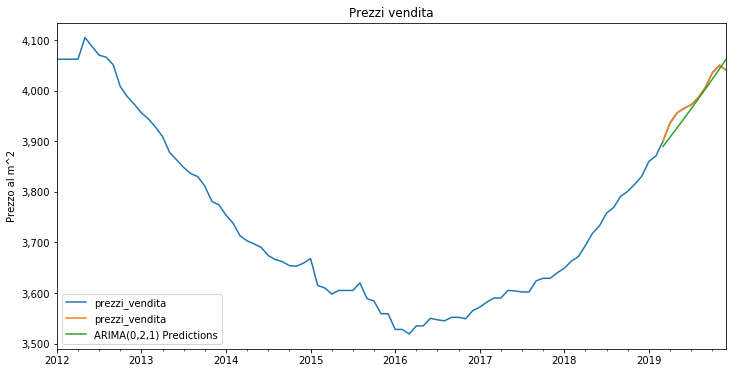

In [202]:
# Plot predictions against known values
title = 'Prezzi vendita'
ylabel='Prezzo al m^2'
xlabel='' # we don't really need a label here

ax = df['prezzi_vendita'].plot(legend=True,figsize=(12,6),title=title)
ax = test['prezzi_vendita'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [203]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['prezzi_vendita'], predictions)
print(f'ARIMA(0,2,1) RMSE Error: {error:11.10}')

ARIMA(0,2,1) RMSE Error: 17.29465933


In [204]:
test['prezzi_vendita'].std()

48.56427585055592

### Retrain the model on the full data, and forecast the future

In [184]:
model = ARIMA(df['prezzi_vendita'],order=(0,2,1))
results = model.fit()
fcast = results.predict(len(df),len(df)+10,typ='levels').rename('ARIMA(0,2,1) Forecast')

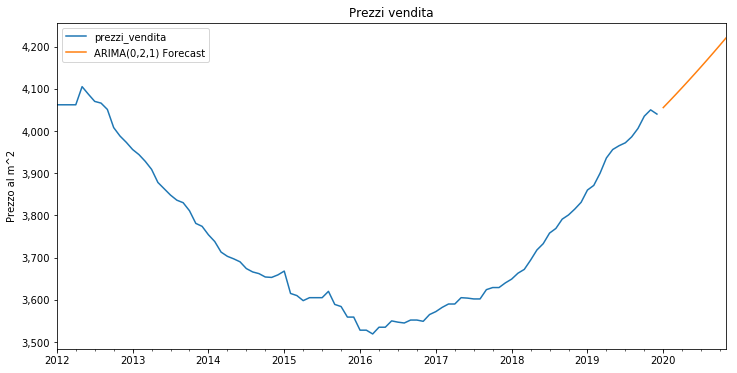

In [185]:
# Plot predictions against known values
title = 'Prezzi vendita'
ylabel='Prezzo al m^2'
xlabel='' # we don't really need a label here

ax = df['prezzi_vendita'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);